# Evaluate the the Bayesian network

## 1. Prepare the session

### 1.1 Load the libraries

In [22]:
# To manipulate data
import pandas as pd
import numpy as np

# To import the model
from joblib import load
import os

# To calculate ROC curve and AUC scores
from sklearn.metrics import roc_auc_score, roc_curve, auc

# For the plot colours
import matplotlib.pyplot as plt
from matplotlib.cm import viridis

### 1.2 Import the model and test data objects

In [2]:
# Define the parent directory
parent_dir = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir)
)

# Define the subfolder directory
output_folder = os.path.join(
    parent_dir, "outputs"
)

# Name of the model output file
file_name1 = "test-data.joblib"
file_name2 = "BayesNet-fit.joblib"

test_df = load(
    os.path.join(output_folder, file_name1)
)

model = load(
    os.path.join(output_folder, file_name2)
)

## 2. Predict based on the testing data

Here we want to predict the probabilities of each hunting succcess classes using the test data. In Dead by Daylight, predators can capture from 0 up to 4 prey. There are thus 5 classes for the hunting success variable.

In [3]:
# Drop hunting success, our target variable from the test dataframe
predict_data = test_df.drop(
    columns = ["hunting_success"]
)

# Predict probabilities for each hunting success class using the trained Bayesian network
pred_probs = model.predict_probability(
    data = predict_data
)

# Extract the labels for the test set (0 to 4)
true_labels = test_df["hunting_success"]

## 3. AUC scores

### 3.1 Extract the predicted values and their labels

In [4]:
# Convert DataFrame to numpy array
pred_probs = pred_probs.values
true_labels = true_labels.values

# Define the number of unique classes (from 0 to 4)
num_classes = 5

### 3.2 Calculate the AUC scores for each class - One vs Rest (OvR)

Here, we are treating each class as a one vs rest where 1 is the value in the range 0 to 4 we are interested in (positive class), and 0 is any other value (negative class).

In [5]:
# Compute AUC for each class
auc_scores = []
for class_index in range(num_classes):
    # Convert true labels to binary classification (1 if class_index, 0 otherwise)
    class_labels = (true_labels == class_index).astype(int)
    # Use the predicted probability of the current class
    class_probs = pred_probs[:, class_index]
    auc = roc_auc_score(class_labels, class_probs)
    auc_scores.append(auc)

### 3.3 AUC scores for each class

Here, I display the results of the AUCs that we calculated for each class.

In [6]:
for class_index, auc in enumerate(auc_scores):
    auc_rounded1 = "{:.3f}".format(auc)
    print(f"AUC for hunting success = {class_index}: {auc_rounded1}")

AUC for hunting success = 0: 0.865
AUC for hunting success = 1: 0.718
AUC for hunting success = 2: 0.639
AUC for hunting success = 3: 0.701
AUC for hunting success = 4: 0.800


### 3.4 Macro-averaged AUC score

Here, I compute the macro-average AUC by taking the average over all the AUC values that we calculated for each class.

In [7]:
# Average AUC scores
average_auc = np.mean(auc_scores)
auc_rounded2 = "{:.3f}".format(average_auc)
print("Average AUC for hunting success:", auc_rounded2)

Average AUC for hunting success: 0.745


### 3.5 Micro-averaged AUC score

This method is advantageous for a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging. In such cases,

In [13]:
# Compute micro-averaged AUC
# Compute ROC curve and AUC for each class separately
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-averaged ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

micro_auc = auc(all_fpr, mean_tpr)
auc_rounded3 = "{:.3f}".format(micro_auc)
print("Micro-averaged AUC:", auc_rounded3)

Micro-averaged AUC: 0.745


### 3.5 Plot AUC scores for each class

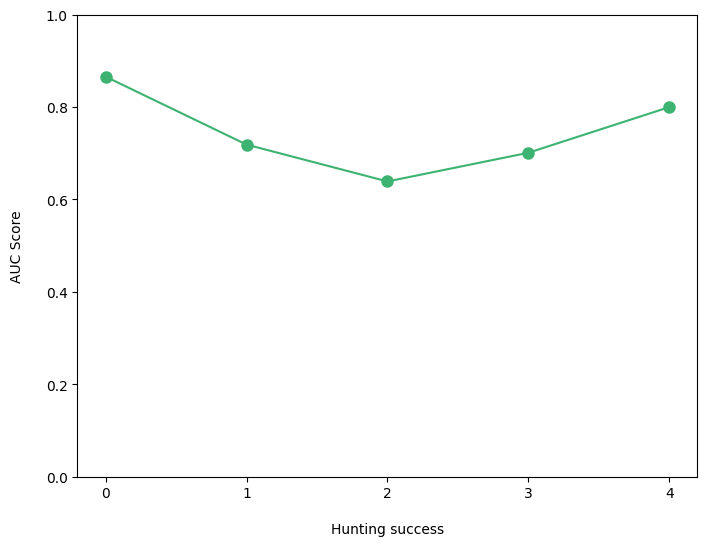

In [9]:
# Assign all classes to object
success_indices = range(5)

# Plot
plt.figure(figsize = (8, 6))
plt.plot(
    success_indices, auc_scores,
    marker = "o", markersize = 8,
    color = "mediumseagreen",
    linestyle = '-'
)
plt.xlabel("\nHunting success")
plt.ylabel('AUC Score\n')
plt.ylim([0, 1])
plt.xticks(success_indices)
plt.grid(False)
plt.show()

### 3.5 Plot the one-vs-rest ROC curves for each class

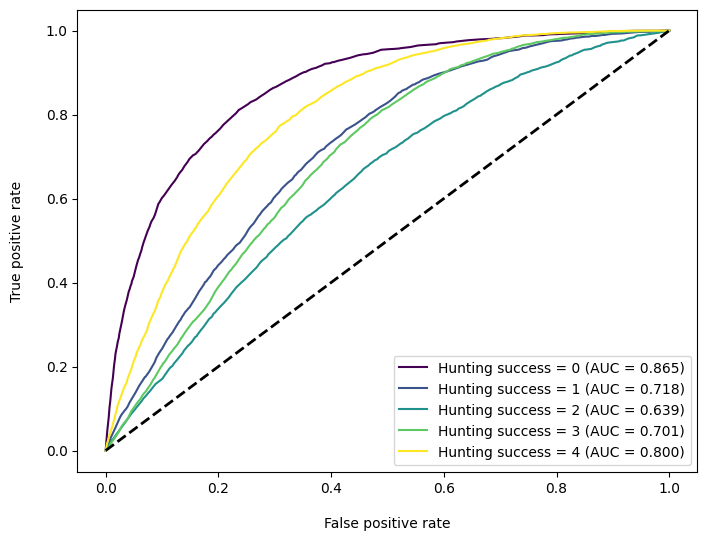

In [24]:
# Compute ROC curve and AUC for each class separately
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(
        true_labels == i,
        pred_probs[:, i]
    )
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize = (8, 6))
viridis_colors = viridis(np.linspace(0, 1, num_classes))
for i in range(num_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        color = viridis_colors[i],
        label = f"Hunting success = {i} (AUC = {roc_auc[i]:.3f})"
    )
 # Plot diagonal dashed line for reference
plt.plot([0, 1], [0, 1], "k--", lw = 2) 
plt.xlabel("\nFalse positive rate")
plt.ylabel("True positive rate\n")
#plt.title("One-vs-Rest ROC Curve for Each Class")
plt.legend(loc = "lower right")
plt.grid(False)
plt.show()
